In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
# import tf-nightly-gpu as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
# tf.debugging.set_log_device_placement(True)
print(tf.__version__)

2.3.1


In [3]:
tf.test.is_built_with_cuda()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
TRAIN_COUNT = 10000

In [6]:
# data = pd.read_excel('Simulation.xlsx')
data = pd.read_excel('data.xlsx')

In [7]:
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

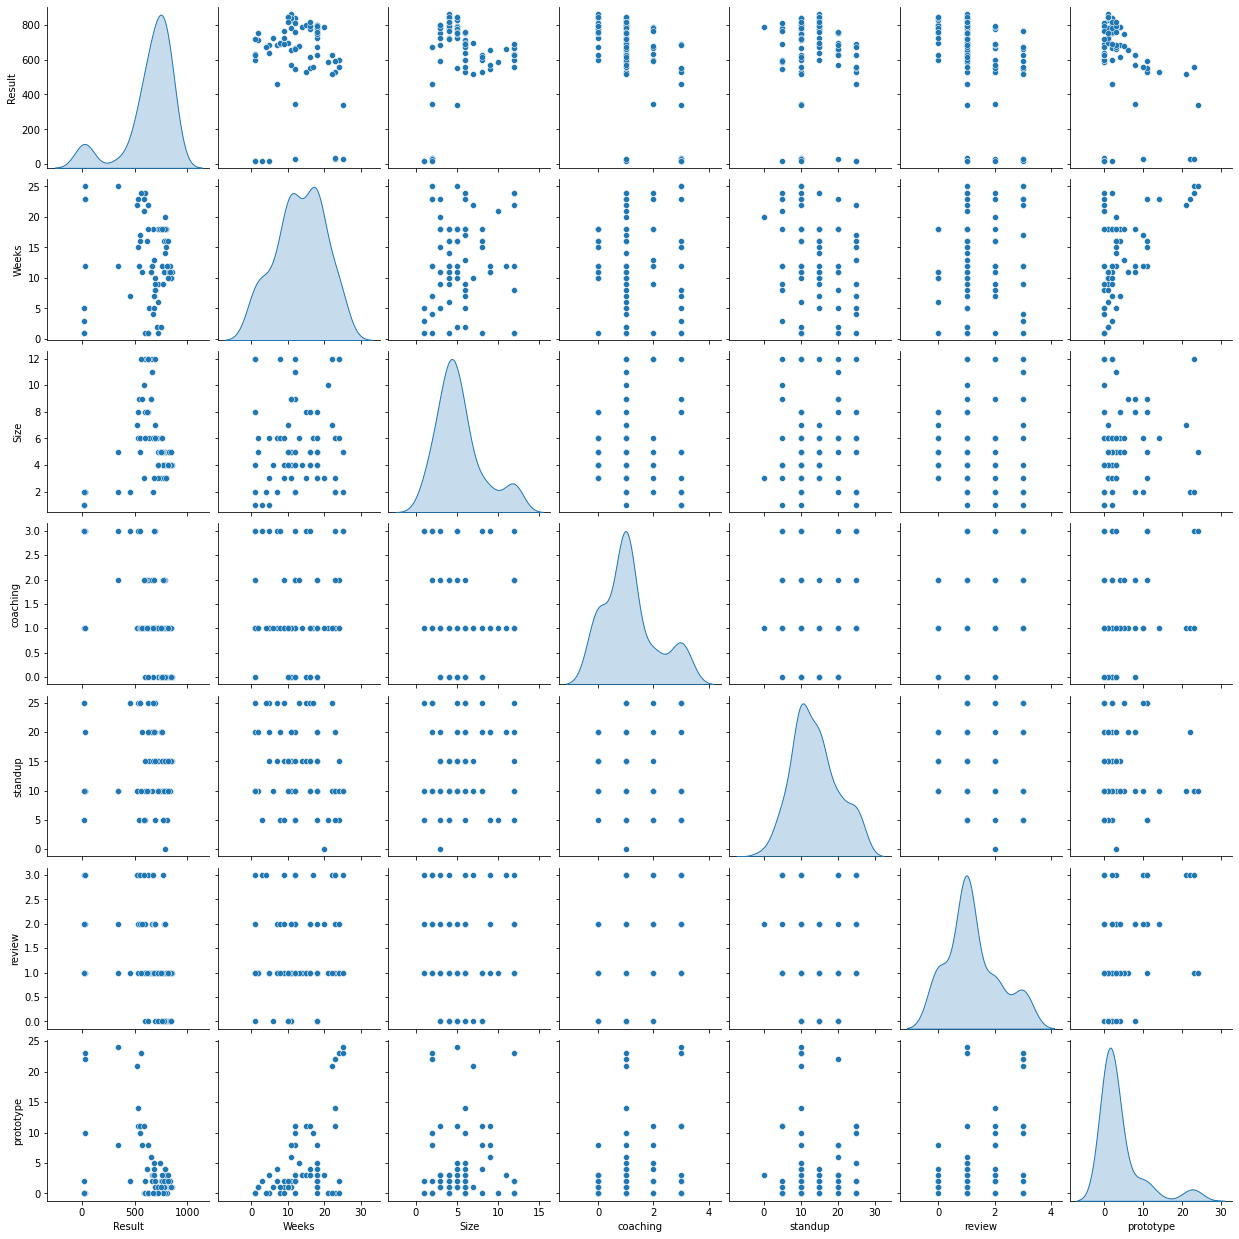

In [8]:
sns.pairplot(train_dataset[['Result', 'Weeks', 'Size', 'coaching', 'standup', 'review','prototype']], diag_kind='kde')

In [9]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Result')
test_labels = test_features.pop('Result')

In [10]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Weeks,13.372093,6.562006
Size,5.302326,2.816213
skill 1,0.325581,0.471340
skill 2,0.220930,0.417307
skill 3,0.186047,0.391427
skill 4,0.267442,0.445221
coaching,1.139535,0.947601
standup,13.779070,5.987047
review,1.220930,0.912671
overtime 1,0.232558,0.424941


In [11]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[13.372  5.302  0.326  0.221  0.186  0.267  1.14  13.779  1.221  0.233
  0.43   0.337  3.884]


In [12]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 1 12  0  0  1  0  2 20  1  1  0  0  0]]

Normalized: [[-1.9   2.39 -0.69 -0.53  2.09 -0.6   0.91  1.05 -0.24  1.82 -0.87 -0.71
  -0.7 ]]


In [13]:
Size = np.array(train_features['Size'])

Size_normalizer = preprocessing.Normalization(input_shape=[1,])
Size_normalizer.adapt(Size)

In [14]:
Size_model = tf.keras.Sequential([
    Size_normalizer,
    layers.Dense(units=16)
])

Size_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 16)                32        
Total params: 35
Trainable params: 32
Non-trainable params: 3
_________________________________________________________________


In [15]:
Size_model.predict(Size[:10])

array([[-0.769, -0.45 ,  0.568,  0.023, -1.073, -0.939, -1.221,  0.269,
         0.505, -0.676,  0.167,  0.074,  1.026,  0.021,  0.392, -0.559],
       [ 0.035,  0.02 , -0.026, -0.001,  0.048,  0.042,  0.055, -0.012,
        -0.023,  0.031, -0.008, -0.003, -0.046, -0.001, -0.018,  0.025],
       [-0.424, -0.248,  0.314,  0.012, -0.593, -0.518, -0.674,  0.148,
         0.279, -0.373,  0.092,  0.041,  0.566,  0.011,  0.216, -0.309],
       [ 0.149,  0.087, -0.11 , -0.004,  0.209,  0.183,  0.237, -0.052,
        -0.098,  0.131, -0.033, -0.014, -0.199, -0.004, -0.076,  0.109],
       [ 0.035,  0.02 , -0.026, -0.001,  0.048,  0.042,  0.055, -0.012,
        -0.023,  0.031, -0.008, -0.003, -0.046, -0.001, -0.018,  0.025],
       [-0.539, -0.316,  0.398,  0.016, -0.753, -0.658, -0.856,  0.188,
         0.354, -0.474,  0.117,  0.052,  0.72 ,  0.015,  0.275, -0.392],
       [-0.08 , -0.047,  0.059,  0.002, -0.112, -0.098, -0.127,  0.028,
         0.053, -0.07 ,  0.017,  0.008,  0.107,  0.002,  0

In [16]:
Size_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    # optimizer=tf.optimizers.Adam(learning_rate=0),
    loss='mean_absolute_error')

In [17]:
class Print(keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs): 
        print (str(epoch)+' / '+str(TRAIN_COUNT), end="\r")

In [18]:
%%time
history = Size_model.fit(
    train_features['Size'], train_labels,
    epochs=TRAIN_COUNT,
    # epochs=1000,
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2,
    callbacks=[Print()]
    )

Wall time: 3min 57s


In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
9995,136.126038,141.038788,9995
9996,136.130814,141.014450,9996
9997,136.134125,140.992279,9997
9998,136.136032,140.972183,9998
9999,136.136566,140.949646,9999


In [20]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Result]')
  plt.legend()
  plt.grid(True)

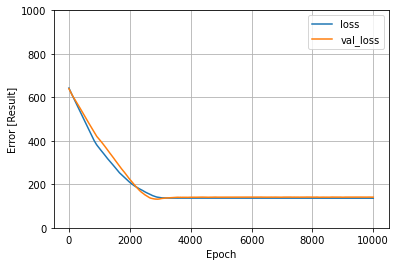

In [21]:
plot_loss(history)

In [22]:
test_results = {}
test_results['Size_model'] = Size_model.evaluate(
    test_features['Size'],
    test_labels, verbose=0)

In [23]:
x = tf.linspace(0.0, 12, 13)
y = Size_model.predict(x)

In [24]:
def plot_Size(x, y):
  plt.scatter(train_features['Size'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Size')
  plt.ylabel('Result')
  plt.legend()

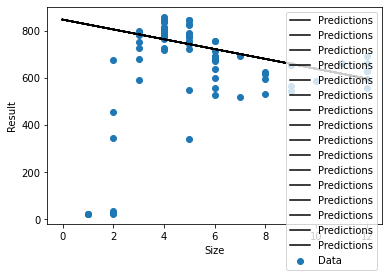

In [25]:
plot_Size(x,y)

In [26]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [27]:
linear_model.predict(train_features[:10])

array([[-2.303],
       [ 0.334],
       [ 2.323],
       [ 0.344],
       [ 0.591],
       [-0.778],
       [ 0.286],
       [-0.031],
       [ 0.067],
       [-1.861]], dtype=float32)

In [28]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(13, 1) dtype=float32, numpy=
array([[-0.248],
       [-0.226],
       [ 0.489],
       [ 0.573],
       [-0.31 ],
       [ 0.131],
       [ 0.524],
       [ 0.525],
       [ 0.368],
       [-0.504],
       [ 0.479],
       [ 0.443],
       [ 0.213]], dtype=float32)>

In [29]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [30]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=TRAIN_COUNT,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2, 
    callbacks=[Print()]
    )

Wall time: 3min 58s


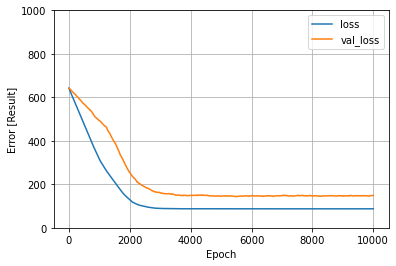

In [31]:
plot_loss(history)

In [32]:

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [33]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(512, activation='relu'),
      layers.Dense(1024, activation='relu'),
      layers.Dense(2048, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(2048, activation='relu'),
      layers.Dense(1024, activation='relu'),
      layers.Dense(512, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
                # optimizer=tf.keras.optimizers.Adam(0.00001))
  return model

In [34]:
dnn_Size_model = build_and_compile_model(Size_normalizer)
dnn_Size_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_7 (Dense)              (None, 2048)             

In [35]:
%%time
history = dnn_Size_model.fit(
    train_features['Size'], train_labels,
    validation_split=0.2,
    # validation_split=0,
    verbose=0, epochs=TRAIN_COUNT, 
    callbacks=[Print()]
    )

Wall time: 5min 48s


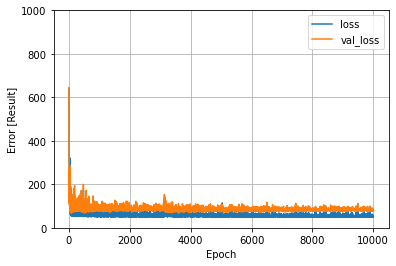

In [36]:
plot_loss(history)

In [37]:
x = tf.linspace(0.0, 12, 13)
y = dnn_Size_model.predict(x)

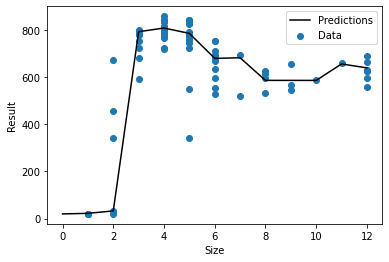

In [38]:
plot_Size(x, y)

In [39]:
test_results['dnn_Size_model'] = dnn_Size_model.evaluate(
    test_features['Size'], test_labels,
    verbose=0)

In [40]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 13)                27        
_________________________________________________________________
dense_16 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_17 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_18 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_19 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_21 (Dense)             (None, 2048)             

In [41]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=TRAIN_COUNT, 
    callbacks=[Print()]
    )

Wall time: 5min 55s


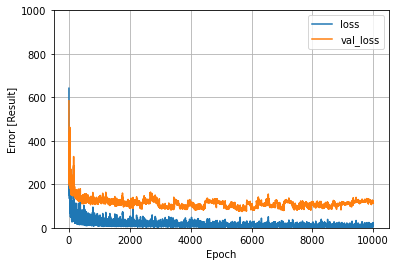

In [42]:
plot_loss(history)

In [43]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [44]:
pd.DataFrame(test_results, index=['Mean absolute error [Result]']).T

,Mean absolute error [Result]
Size_model,117.698517
linear_model,77.664314
dnn_Size_model,98.727341
dnn_model,39.473095


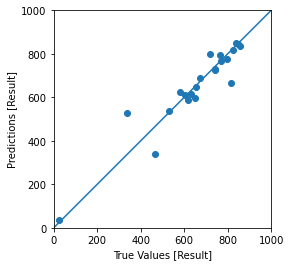

In [45]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Result]')
plt.ylabel('Predictions [Result]')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

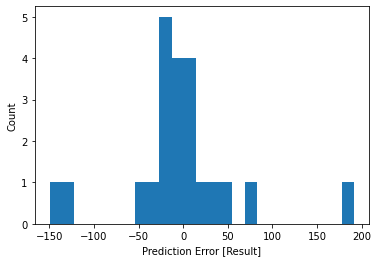

In [46]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Result]')
_ = plt.ylabel('Count')

In [47]:
dnn_model.save('dnn_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: dnn_model\assets
